In [5]:
"""
    Notebook to explore embedding space for members and non-members for few-shot learning to see if any useful trends exist that can be utilized
    by adversary.
"""
import torch as ch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from distribution_inference.datasets.utils import get_dataset_wrapper
from distribution_inference.config.core import DatasetConfig, RelationConfig
from dataclasses import replace

from distribution_inference.training.utils import load_model
import distribution_inference.models.contrastive as models_contrastive
from distribution_inference.attacks.blackbox.utils import get_relation_preds
from tqdm import tqdm

# Set DPI to 300 for better quality
plt.rcParams['figure.dpi'] = 300


In [6]:
@ch.no_grad()
def collect_embeddings(model, loader):
    """
        Collect embeddings for a given model and loader
    """
    embeddings, labels = [], []
    for batch in tqdm(loader, desc="Collecting embeddings"):
        embed = model(batch[0].cuda(), embedding_mode=True).detach().cpu().numpy()
        embeddings.append(embed)
        labels.append(batch[1].numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    # Flatten out embeddings:
    embeddings = embeddings.reshape(embeddings.shape[0], -1)
    labels = np.concatenate(labels, axis=0)
    return embeddings, labels

In [16]:
def look_at_metrics(embeds):
    centroid = np.mean(embeds, axis=0)
    # Distances from all points to centroid
    dists = np.linalg.norm(embeds - centroid, axis=1).mean()
    # Distances from all points to each other
    dists2 = np.linalg.norm(embeds[:, None] - embeds[None, :], axis=2).mean()
    return dists, dists2

In [41]:
def experiment(ds_adv, ds_victim,
               victim_model_path: str,
               batch_size: int = 128,
               n_people: int = 5,
               skip_plot: bool = False):
    # Load victim model
    victim_model = models_contrastive.SCNNFaceAudit(n_people=10)
    victim_model, (train_people, _) = load_model(victim_model, path=victim_model_path, on_cpu=True)
    victim_model.cuda()
    victim_model.eval()

    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(train_people, shuffle=True, batch_size=batch_size)
    # Get loader for adversary (use test people for now)
    _, loader_nonmembers = ds_adv.get_loaders(shuffle=True, batch_size=batch_size, primed_for_training=False)

    # Collect embeddings
    member_embeds, member_labels = collect_embeddings(victim_model, loader_members)
    nonmember_embeds, nonmember_labels = collect_embeddings(victim_model, loader_nonmembers)

    # Pick n_people random people from nonmember_labels
    random_nonmembers = np.random.choice(np.unique(nonmember_labels), size=n_people, replace=False)
    # Keep only embeddings for these people
    nonmember_embeds = nonmember_embeds[np.isin(nonmember_labels, random_nonmembers)]
    nonmember_labels = nonmember_labels[np.isin(nonmember_labels, random_nonmembers)]

    # Gather some metrics
    member_metrics = np.array([look_at_metrics(member_embeds[member_labels == i]) for i in np.unique(member_labels)])
    nonmember_metrics = np.array([look_at_metrics(nonmember_embeds[nonmember_labels == i]) for i in np.unique(nonmember_labels)])

    if skip_plot:
        return member_metrics, nonmember_metrics

    # Create colors array such that each person has a unique color
    unique_colors = np.unique(np.concatenate([member_labels, nonmember_labels]))
    num_colors = len(unique_colors)
    # Create colormap
    cmap = plt.cm.get_cmap('tab10', num_colors)
    # Create color array
    member_labels = [cmap(np.where(unique_colors == i)[0][0]) for i in member_labels]
    nonmember_labels = [cmap(np.where(unique_colors == i)[0][0]) for i in nonmember_labels]

    # Combine embeddings
    embeds = np.concatenate([member_embeds, nonmember_embeds], axis=0)

    # Get t-SNE embeddings
    tsne = TSNE(n_components=2, random_state=2023)
    tsne_embeds = tsne.fit_transform(embeds)

    # Plot member-corresponding data with marker as 'x'
    plt.scatter(tsne_embeds[:len(member_labels), 0], tsne_embeds[:len(member_labels), 1], c=member_labels, marker='x', cmap='tab10')
    # Plot nonmember-corresponding data with marker as 'o'
    plt.scatter(tsne_embeds[len(member_labels):, 0], tsne_embeds[len(member_labels):, 1], c=nonmember_labels, marker='o', cmap='tab10')

    plt.show()

    return member_metrics, nonmember_metrics

In [46]:
def relational_experiment(ds_adv, ds_victim,
                          victim_model_path: str,
                          batch_size: int = 128,
                          n_people: int = 5,
                          skip_plot: bool = False):
    # Load victim model
    victim_model = models_contrastive.SCNNFaceAudit(n_people=10)
    victim_model, (train_people, _) = load_model(
        victim_model, path=victim_model_path, on_cpu=True)
    victim_model.cuda()
    victim_model.eval()

    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(
        train_people, shuffle=True, batch_size=batch_size)
    # Get loader for adversary (use test people for now)
    _, loader_nonmembers = ds_adv.get_loaders(
        shuffle=True, batch_size=batch_size, primed_for_training=False)
    
    def _collect_matching(loader, id):
        mapping = {}
        for batch in loader:
            img = batch[0]
            lbl = batch[1]
            for i, l in enumerate(lbl):
                if l not in mapping:
                    mapping[l] = []
                mapping[l].append(img[i])
        return mapping

    member_map = _collect_matching(loader_members, 0)
    support_map = _collect_matching(loader_members, 1)
    # Flatten support_map into nested list from dict of lists
    support_images = [ch.cat(support_map[k], 0).cuda() for k in support_map]

    # Handle query set for each member person one by one
    train_people_labels = np.unique(train_people)
    all_rvals = []
    for q in train_people_labels:
        query_images = ch.cat(member_map[q], 0).cuda()
        relation_values = get_relation_preds(support_images, query_images, [victim_model], verbose=True)
        all_rvals.append(relation_values)
    return all_rvals


SyntaxError: invalid syntax (170751618.py, line 77)

In [23]:
model_paths = [
    "/p/adversarialml/as9rw/models_celeba_person/80_20_split/scnn_relation/victim/1/0.0/1_0.90.ch",
    "/p/adversarialml/as9rw/models_celeba_person/80_20_split/scnn_relation/victim/1/0.0/2_0.90.ch"
]

rel_config = RelationConfig(n_way=5, k_shot=5, num_query_train=5, num_query_test=5, test_num_task=80)
base_config = DatasetConfig(name="celeba_person", prop=1, classify=None,
                            split="victim", value=False, augment=False, relation_config=rel_config)
adv_config = replace(base_config, split="adv")

# Get dataset wrapper
ds_wrapper_class = get_dataset_wrapper("celeba_person")


# Create DS objects
ds_vic = ds_wrapper_class(base_config)
ds_adv = ds_wrapper_class(adv_config)

In [42]:
index = 1
mem, nonmem = experiment(ds_adv, ds_vic, model_paths[index], n_people=50, skip_plot=True)

In [43]:
mem

array([[52.9194  , 73.429054],
       [48.003635, 66.63356 ],
       [49.24732 , 68.3181  ],
       [49.99779 , 69.63192 ],
       [52.223198, 72.56806 ],
       [52.885254, 73.00207 ],
       [51.403805, 71.161674],
       [49.675907, 68.81416 ],
       [50.788036, 70.4178  ],
       [49.400497, 68.738365],
       [50.325035, 69.92495 ],
       [53.987602, 74.486885],
       [51.738514, 71.967155],
       [53.017647, 73.127556],
       [52.86187 , 73.604034],
       [46.216328, 64.368286],
       [53.09844 , 73.86315 ],
       [49.04713 , 67.79342 ],
       [50.134148, 68.94645 ],
       [52.028996, 72.44901 ],
       [50.86101 , 70.232666],
       [53.3249  , 74.20371 ],
       [50.217396, 69.45193 ],
       [52.15159 , 72.399925],
       [51.29672 , 70.88846 ],
       [55.12678 , 76.665215],
       [51.76286 , 71.71141 ],
       [50.7896  , 70.65966 ],
       [53.79762 , 74.76754 ],
       [51.951435, 71.76145 ],
       [50.34871 , 69.96307 ],
       [52.355152, 72.47464 ],
       [

In [44]:
nonmem

array([[53.350304, 74.051636],
       [54.732616, 76.10981 ],
       [52.65871 , 73.23374 ],
       [51.415714, 71.43139 ],
       [54.366547, 75.306274],
       [53.52079 , 74.45516 ],
       [53.612556, 74.00986 ],
       [50.4199  , 69.37543 ],
       [51.614155, 71.65016 ],
       [55.111057, 76.573524],
       [54.77948 , 76.09276 ],
       [49.942   , 69.14336 ],
       [51.78936 , 72.04028 ],
       [51.818413, 72.169586],
       [52.811924, 72.90627 ],
       [50.28319 , 69.44859 ],
       [47.99787 , 66.71631 ],
       [53.60613 , 74.55159 ],
       [53.33048 , 74.13255 ],
       [51.47933 , 71.70819 ],
       [53.439087, 74.2416  ],
       [55.1475  , 76.72871 ],
       [48.671177, 67.068375],
       [53.730633, 74.235275],
       [50.361374, 69.615425],
       [51.50388 , 71.65975 ],
       [54.80468 , 76.12955 ],
       [50.89718 , 70.76041 ],
       [51.614136, 71.55613 ],
       [51.589912, 71.25009 ],
       [54.06504 , 75.194466],
       [51.171032, 71.171265],
       [

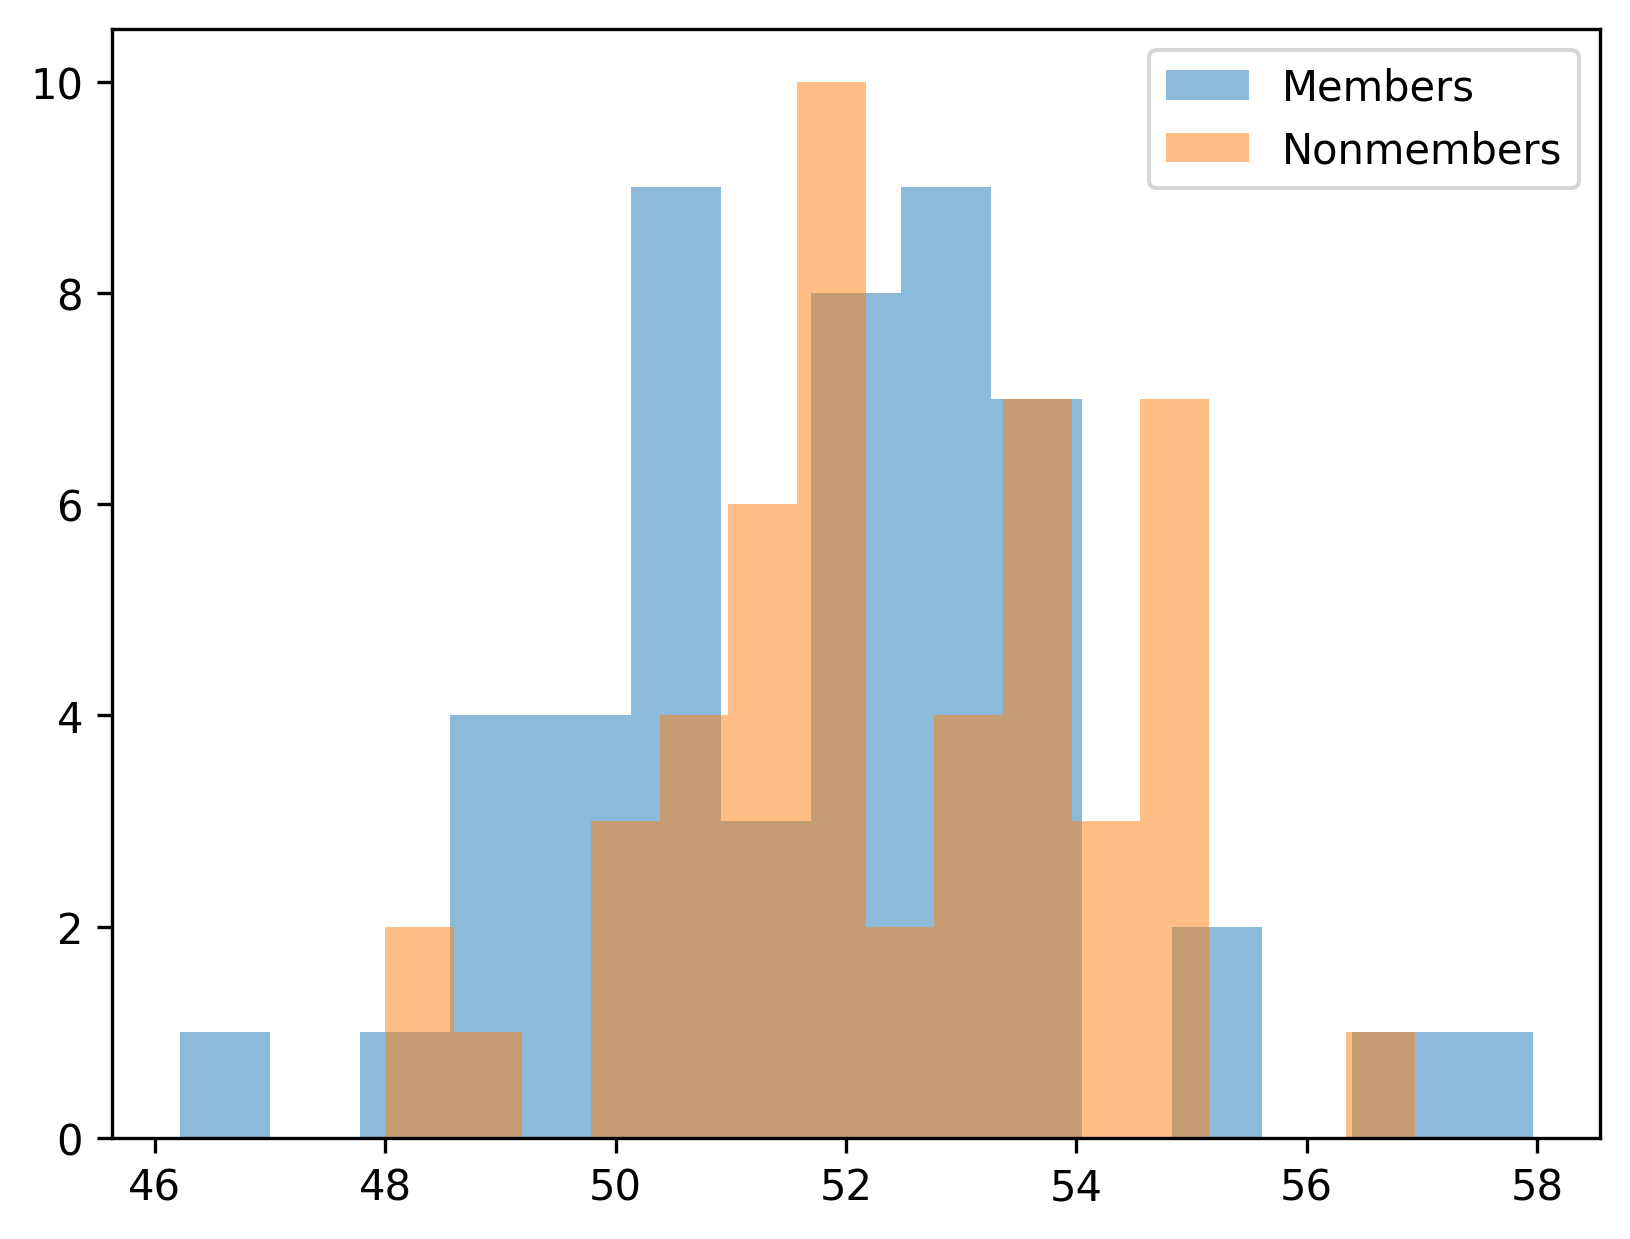

In [45]:
plt.hist(mem[:, 0], bins=15, alpha=0.5, label="Members")
plt.hist(nonmem[:, 0], bins=15, alpha=0.5, label="Nonmembers")
plt.legend()